<p style="font-size:16px;">
    This is a testing notebook for trying the NRI variant model before commiting to properly training it. Not only that, it allows for easier and more interactive visualizations once we have the trained weights.
</p>
<p style="font-size:16px;">
    It is divided into 3 main parts:
    <ul style="font-size:16px;">
        <li><b>Data Preparation:</b> Loading data, visualizing it to better understand the inputs, preparing it with the appropriate shape and data structure for the models, and finally augmenting it for better training.</li>
        <li><b>Building Models:</b> Defining the model and testing small training instances to check if the pipeline is working</li>
        <li><b>Visualizations:</b> Implementing various types of visualizations given the trained model to benefit from their insights</li>
    </ul>
</p>

# Data Preparation

<ul style="font-size:16px;">
    <li>Reading preprocessed data in an interleaved manner to extract data from both dancers separately. For better movement prediction and velocity estimation, we only read every 5th frame</li>
    <li>Creating adjacencies by:
        <ol>
            <li>Initializing default skeleton for 29 joints</li>
            <li>Repeating the process for the second dancer</li>
            <li>Connecting every joint of a dancer to all joints on the other dancer (these are the ones we want to classify as existing or non-existing with the NRI model)</li>
            <li>Duplicating the edges to make graph undirected</li>
        </ol>
    </li>
    <li>Visualizing both dancers with their default skeletons and also with the connecting edges</li>
    <li>Estimating velocities based on 3D positions of consecutive frames</li>
    <li>Preparing batches with PyTorch tensors of shape (batches, length_of_sequences, number_of_joints_from_both_dancers, 6D (position + velocity))</li>
    <li>Creating training-validation split</li>
    <li>To simplify the problem even further and better utilize the potential of the proposed architecture, in light of the amount of data available, a final sampling step of the dancers' joints is applied, resulting in fewer particles to be tracked</li>
</ul>

In [1]:
from IPython.core.debugger import set_trace
from glob import glob
import numpy as np

# Reading data coming from the pre-processing pipeline and creating both dancers
joint_poses = []
for file in glob('./data/*.npy'):
    interleaved_poses = np.load(file)
    poses_1 = interleaved_poses[0::2]
    poses_2 = interleaved_poses[1::2]

    # Sampling frames for movement smoothness
    joint_poses.append(np.concatenate((poses_1, poses_2), axis=1)[::5])
    print('Joint poses {} shape: {}\n'.format(file.split('/')[-1], joint_poses[-1].shape))

Joint poses pose_extraction_ilya_hannah_dyads.npy shape: (2712, 58, 3)

Joint poses pose_extraction_dyads_rehearsal_leah.npy shape: (4285, 58, 3)

Joint poses pose_extraction_img_9085.npy shape: (3844, 58, 3)

Joint poses pose_extraction_hannah_cassie.npy shape: (3914, 58, 3)



In [2]:
# Building initial transposed edge index (adjacencies)
edge_index_t = [[0, 1], [0, 2], [0, 3], [1, 4], [2, 5], [3, 6], [4, 7], [5, 8], [6, 9], [7, 10], [7, 27], [8, 11],
                [8, 28], [9, 12], [9, 13], [9, 14], [12, 15], [13, 16], [14, 17], [15, 24], [16, 18], [17, 19],
                [18, 20], [19, 21], [20, 22], [21, 23], [22, 25], [23, 26]]

# Getting second person skeleton
n_joints = int(joint_poses[0].shape[1]/2)
init_skeleton_len = len(edge_index_t)
for edge_index in range(init_skeleton_len):
    edge_index_t.append([edge_index_t[edge_index][0]+n_joints, edge_index_t[edge_index][1]+n_joints])

# Saving skeletons for visualization
skeletons = edge_index_t.copy()

# Fully connecting the two people
for joint_1 in range(interleaved_poses.shape[1]):
    for joint_2 in range(interleaved_poses.shape[1]):
        edge_index_t.append([joint_1, joint_2+n_joints])

# Making graph undirected
full_skeleton_len = len(edge_index_t)
for edge_index in range(full_skeleton_len):
    edge_index_t.append([edge_index_t[edge_index][1], edge_index_t[edge_index][0]])

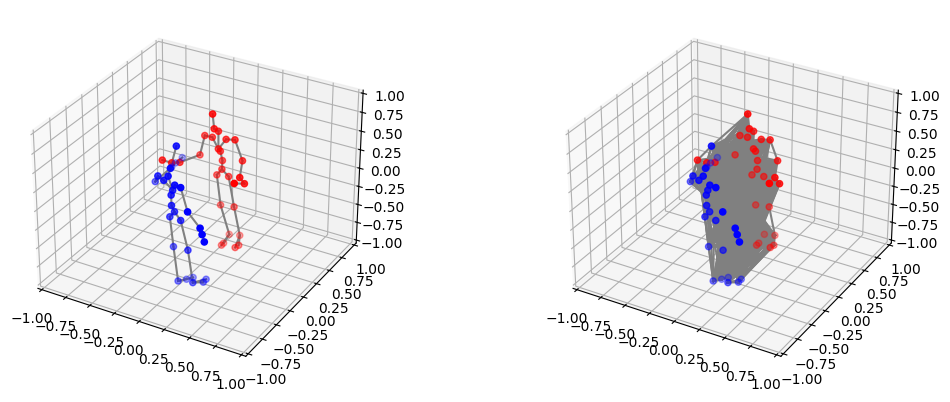

In [3]:
# Visualizing joint skeletons for random frame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

fig = plt.figure(figsize=(12, 4))

# Plotting dancers
ax1 = fig.add_subplot(121, projection="3d")
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_zlim([-1, 1])

rand_frame = 0
ax1.scatter(joint_poses[0][rand_frame, :n_joints, 2], joint_poses[0][rand_frame, :n_joints, 0], \
            -joint_poses[0][rand_frame, :n_joints, 1], color='red')
ax1.scatter(joint_poses[0][rand_frame, n_joints:, 2], joint_poses[0][rand_frame, n_joints:, 0], \
            -joint_poses[0][rand_frame, n_joints:, 1], color='blue')

for (start, end) in skeletons:
    xs = [joint_poses[0][rand_frame, start, 2], joint_poses[0][rand_frame, end, 2]]
    ys = [joint_poses[0][rand_frame, start, 0], joint_poses[0][rand_frame, end, 0]]
    zs = [-joint_poses[0][rand_frame, start, 1], -joint_poses[0][rand_frame, end, 1]]
    ax1.plot(xs, ys, zs, color='grey')

# Plotting dancers with fully connected joints
ax2 = fig.add_subplot(122, projection="3d")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_zlim([-1, 1])

ax2.scatter(joint_poses[0][rand_frame, :n_joints, 2], joint_poses[0][rand_frame, :n_joints, 0], \
            -joint_poses[0][rand_frame, :n_joints, 1], color='red')
ax2.scatter(joint_poses[0][rand_frame, n_joints:, 2], joint_poses[0][rand_frame, n_joints:, 0], \
            -joint_poses[0][rand_frame, n_joints:, 1], color='blue')

for (start, end) in edge_index_t[:int(len(edge_index_t)/2)]:
    xs = [joint_poses[0][rand_frame, start, 2], joint_poses[0][rand_frame, end, 2]]
    ys = [joint_poses[0][rand_frame, start, 0], joint_poses[0][rand_frame, end, 0]]
    zs = [-joint_poses[0][rand_frame, start, 1], -joint_poses[0][rand_frame, end, 1]]
    ax2.plot(xs, ys, zs, color='grey')

plt.tight_layout()
plt.show()

In [4]:
#################### Removed piece of code because now we rotate randomly on the fly while training ####################

# # Defining rotation functions
# def rotation_matrix_x(angle):
#     c, s = np.cos(angle), np.sin(angle)
    
#     return np.array([[1, 0, 0],
#                      [0, c, -s],
#                      [0, s, c]])

# def rotation_matrix_y(angle):
#     c, s = np.cos(angle), np.sin(angle)
    
#     return np.array([[c, 0, s],
#                      [0, 1, 0],
#                      [-s, 0, c]])

# def rotation_matrix_z(angle):
#     c, s = np.cos(angle), np.sin(angle)
    
#     return np.array([[c, -s, 0],
#                      [s, c, 0],
#                      [0, 0, 1]])

# def rotate_points(points, angle_x, angle_y, angle_z):
#     Rx = rotation_matrix_x(angle_x)
#     Ry = rotation_matrix_y(angle_y)
#     Rz = rotation_matrix_z(angle_z)
    
#     rotation_matrix = Rz @ Ry @ Rx
#     rotated_points = points @ rotation_matrix.T
    
#     return rotated_points

# # Augmenting poses by adding random rotations (around Z-axis only)
# rand_rot_num = 0
# joint_poses_augmented = [joint_poses]
# for r in range(rand_rot_num):
#     joint_poses_rot = []
    
#     angle_x = 0 # 2*np.random.rand(1)[0]*np.pi
#     angle_y = 2*np.random.rand(1)[0]*np.pi
#     angle_z = 0 # 2*np.random.rand(1)[0]*np.pi
    
#     for choreo in joint_poses:
#         choreo_aux = []
        
#         for frame in choreo:
#             rotated_points = rotate_points(frame, angle_x, angle_y, angle_z)    
#             choreo_aux.append(rotated_points)
            
#         joint_poses_rot.append(np.array(choreo_aux))

#     joint_poses_augmented.append(joint_poses_rot)

# # Visualizing rotated frame
# fig = plt.figure(figsize=(12, 4))

# ax1 = fig.add_subplot(131, projection="3d")
# ax1.set_xlim([-1, 1])
# ax1.set_ylim([-1, 1])
# ax1.set_zlim([-1, 1])

# ax2 = fig.add_subplot(132, projection="3d")
# ax2.set_xlim([-1, 1])
# ax2.set_ylim([-1, 1])
# ax2.set_zlim([-1, 1])

# ax3 = fig.add_subplot(133, projection="3d")
# ax3.set_xlim([-1, 1])
# ax3.set_ylim([-1, 1])
# ax3.set_zlim([-1, 1])

# ax1.scatter(joint_poses[0][0, :n_joints, 2], joint_poses[0][0, :n_joints, 0], -joint_poses[0][0, :n_joints, 1], color='red')
# ax1.scatter(joint_poses[0][0, n_joints:, 2], joint_poses[0][0, n_joints:, 0], -joint_poses[0][0, n_joints:, 1], color='blue')

# ax2.scatter(joint_poses_augmented[1][0][0, :n_joints, 2], joint_poses_augmented[1][0][0, :n_joints, 0], \
#             -joint_poses_augmented[1][0][0, :n_joints, 1], color='red')
# ax2.scatter(joint_poses_augmented[1][0][0, n_joints:, 2], joint_poses_augmented[1][0][0, n_joints:, 0], \
#             -joint_poses_augmented[1][0][0, n_joints:, 1], color='blue')

# ax3.scatter(joint_poses_augmented[2][0][0, :n_joints, 2], joint_poses_augmented[2][0][0, :n_joints, 0], \
#             -joint_poses_augmented[2][0][0, :n_joints, 1], color='red')
# ax3.scatter(joint_poses_augmented[2][0][0, n_joints:, 2], joint_poses_augmented[2][0][0, n_joints:, 0], \
#             -joint_poses_augmented[2][0][0, n_joints:, 1], color='blue')

# plt.tight_layout()
# plt.show()

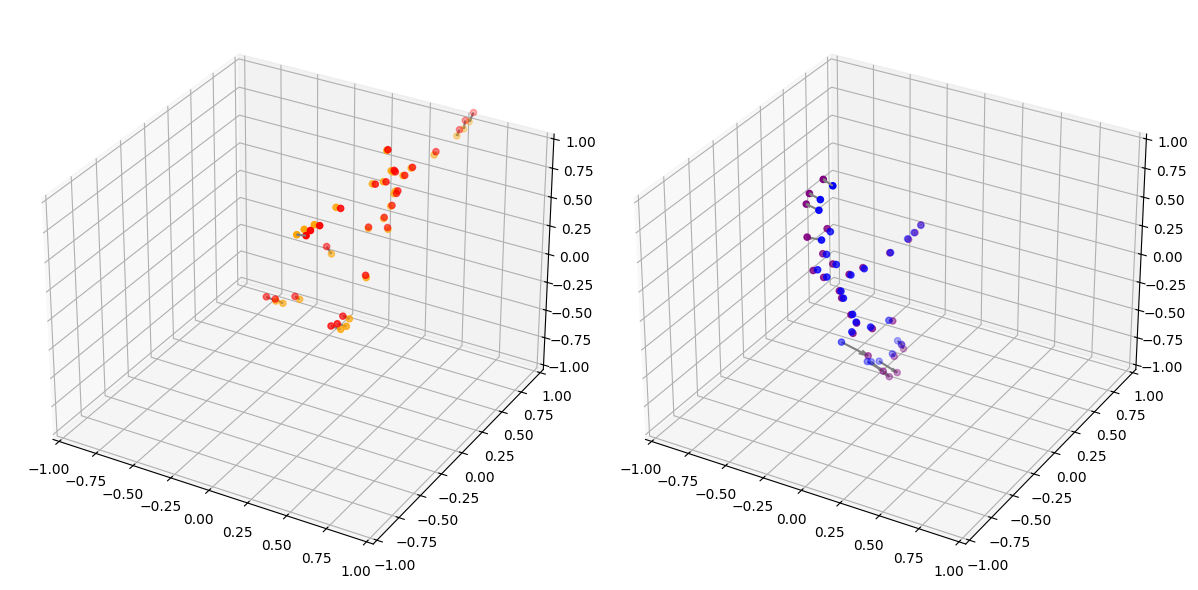

In [5]:
import torch

# Defining velocity function
def compute_velocities(data, frame_gap=2):
    velocities = data[frame_gap:] - data[:-frame_gap]

    # Repeating velocity for final frames
    padding = velocities[-1, :, :].repeat(frame_gap, 1, 1)

    velocities = torch.cat((velocities, padding), dim=0)
    
    # Fixing velocity configuration
    velocities = velocities[:, :, [2, 0, 1]]
    velocities[:, :, 2] = -velocities[:, :, 2]
    
    return velocities

# Estimating velocity of points
frame_gap = 1
velocities = []
joint_poses_velo = []
for joint_pose in [joint_poses]:
    velocities_aux = []
    joint_poses_velo_aux = []
    
    for choreo in joint_pose:
        choreo = torch.Tensor(choreo)
    
        velocity_choreo = compute_velocities(choreo, frame_gap)
        velocities_aux.append(velocity_choreo)
        
        joint_poses_velo_aux.append(torch.cat((choreo, velocity_choreo), dim=-1))

    velocities.append(velocities_aux)
    joint_poses_velo.append(joint_poses_velo_aux)

# Visualizing velocity of points
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection="3d")
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_zlim([-1, 1])

ax2 = fig.add_subplot(122, projection="3d")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_zlim([-1, 1])

rand_frame = 250
ax1.scatter(joint_poses[1][rand_frame, :n_joints, 2], joint_poses[1][rand_frame, :n_joints, 0], \
            -joint_poses[1][rand_frame, :n_joints, 1], color='red')
ax1.scatter(joint_poses[1][rand_frame+frame_gap, :n_joints, 2], joint_poses[1][rand_frame+frame_gap, :n_joints, 0], \
            -joint_poses[1][rand_frame+frame_gap, :n_joints, 1], color='orange')

ax2.scatter(joint_poses[1][rand_frame, n_joints:, 2], joint_poses[1][rand_frame, n_joints:, 0], \
            -joint_poses[1][rand_frame, n_joints:, 1], color='blue')
ax2.scatter(joint_poses[1][rand_frame+frame_gap, n_joints:, 2], joint_poses[1][rand_frame+frame_gap, n_joints:, 0], \
            -joint_poses[1][rand_frame+frame_gap, n_joints:, 1], color='purple')

for point in range(2*n_joints):
    x_start = joint_poses[1][rand_frame, point, 2]
    y_start = joint_poses[1][rand_frame, point, 0]
    z_start = -joint_poses[1][rand_frame, point, 1]

    vx = velocities[0][1][rand_frame, point, 0]
    vy = velocities[0][1][rand_frame, point, 1]
    vz = velocities[0][1][rand_frame, point, 2]
    
    if point < n_joints:
        ax1.quiver(x_start, y_start, z_start, vx, vy, vz, color='grey')
    else:
        ax2.quiver(x_start, y_start, z_start, vx, vy, vz, color='grey')

plt.tight_layout()
plt.show()

In [6]:
import torch

seq_len = 16
batches = []
choreo_lens = []

# Building non-overlapping sequences
for joint_poses_rot_velo in joint_poses_velo:
    for choreo in joint_poses_rot_velo:
        choreo = torch.Tensor(choreo)
    
        num_seqs = choreo.shape[0] // seq_len
        batches.append(torch.stack([choreo[i*seq_len:(i+1)*seq_len] for i in range(num_seqs)]))
        choreo_lens.append(batches[-1].size(0))

# # Building overlapping sequences
# for joint_poses_rot_velo in joint_poses_velo:
#     for choreo in joint_poses_rot_velo:
#         choreo = torch.Tensor(choreo)
    
#         batches.append(torch.stack([choreo[i:i+seq_len] for i in range(len(choreo)-seq_len)]))
#         choreo_lens.append(batches[-1].size(0))

batches = torch.cat(batches, dim=0)

# Fixing x, y, z configuration
batches[:, :, :, [0, 1, 2]] = batches[:, :, :, [2, 0, 1]]
batches[:, :, :, 2] = -batches[:, :, :, 2]

# Balanced training-validation split
train_split = []
val_split = []
train_batches = []
val_batches = []
next_choreo = 0
for choreo_len in choreo_lens:
    
    train_split.append(int(0.85*choreo_len))
    val_split.append(choreo_len - train_split[-1])
    
    train_batches.append(batches[next_choreo : next_choreo + train_split[-1]])
    val_batches.append(batches[next_choreo + train_split[-1] : next_choreo + choreo_len])
    
    next_choreo += choreo_len

train_batches = torch.cat(train_batches, dim=0)
val_batches = torch.cat(val_batches, dim=0)

# Printing all the data structures created
print('Shape of tensor with all sequences: {}'.format(batches.shape))
print('Length of each choreography: {}\n'.format(choreo_lens))

print('Shape of training data with all sequences: {}'.format(train_batches.shape))
print('Length of each choreography in training dataset: {}\n'.format(train_split))

print('Shape of validation data with all sequences: {}'.format(val_batches.shape))
print('Length of each choreography in validation dataset: {}\n'.format(val_split))

Shape of tensor with all sequences: torch.Size([920, 16, 58, 6])
Length of each choreography: [169, 267, 240, 244]

Shape of training data with all sequences: torch.Size([780, 16, 58, 6])
Length of each choreography in training dataset: [143, 226, 204, 207]

Shape of validation data with all sequences: torch.Size([140, 16, 58, 6])
Length of each choreography in validation dataset: [26, 41, 36, 37]



Sampled joints for dancer 1: [11 22  4 25  4], and dancer 2: [51 49 55 31 29]
Shape of sampled data with all sequences: torch.Size([920, 16, 10, 6])
Shape of sampled training data with all sequences: torch.Size([780, 16, 10, 6])
Shape of sampled validation data with all sequences: torch.Size([140, 16, 10, 6])


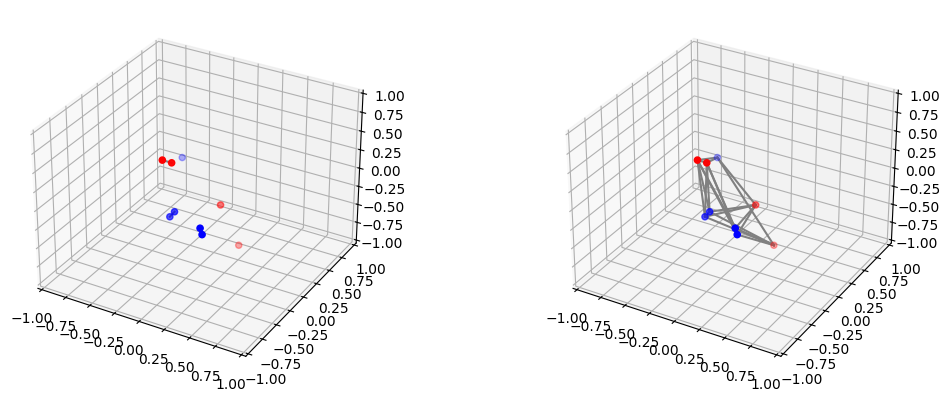

In [27]:
# Sampling dancers joints to simplify problem
n_joints_sampled = 5
sampled_joints_1 = np.random.choice(n_joints, n_joints_sampled)
sampled_joints_2 = np.random.choice(n_joints, n_joints_sampled) + 29
sampled_joints = np.concatenate([sampled_joints_1, sampled_joints_2])
print("Sampled joints for dancer 1: {}, and dancer 2: {}".format(sampled_joints_1, sampled_joints_2))

sampled_batches = batches[:, :, sampled_joints, :]
sampled_train_batches = train_batches[:, :, sampled_joints, :]
sampled_val_batches = val_batches[:, :, sampled_joints, :]

print('Shape of sampled data with all sequences: {}'.format(sampled_batches.shape))
print('Shape of sampled training data with all sequences: {}'.format(sampled_train_batches.shape))
print('Shape of sampled validation data with all sequences: {}'.format(sampled_val_batches.shape))

# Plotting sampled dancers
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121, projection="3d")
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_zlim([-1, 1])

rand_frame = 0
ax1.scatter(joint_poses[0][rand_frame, sampled_joints_1, 2], joint_poses[0][rand_frame, sampled_joints_1, 0], \
            -joint_poses[0][rand_frame, sampled_joints_1, 1], color='red')
ax1.scatter(joint_poses[0][rand_frame, sampled_joints_2, 2], joint_poses[0][rand_frame, sampled_joints_2, 0], \
            -joint_poses[0][rand_frame, sampled_joints_2, 1], color='blue')

for (start, end) in skeletons:
    if (start not in sampled_joints) or (end not in sampled_joints):
        continue
    
    xs = [joint_poses[0][rand_frame, start, 2], joint_poses[0][rand_frame, end, 2]]
    ys = [joint_poses[0][rand_frame, start, 0], joint_poses[0][rand_frame, end, 0]]
    zs = [-joint_poses[0][rand_frame, start, 1], -joint_poses[0][rand_frame, end, 1]]
    ax1.plot(xs, ys, zs, color='grey')

# Plotting sampled dancers with fully connected joints
ax2 = fig.add_subplot(122, projection="3d")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_zlim([-1, 1])

ax2.scatter(joint_poses[0][rand_frame, sampled_joints_1, 2], joint_poses[0][rand_frame, sampled_joints_1, 0], \
            -joint_poses[0][rand_frame, sampled_joints_1, 1], color='red')
ax2.scatter(joint_poses[0][rand_frame, sampled_joints_2, 2], joint_poses[0][rand_frame, sampled_joints_2, 0], \
            -joint_poses[0][rand_frame, sampled_joints_2, 1], color='blue')

for (start, end) in edge_index_t[:int(len(edge_index_t)/2)]:
    if (start not in sampled_joints) or (end not in sampled_joints):
        continue
        
    xs = [joint_poses[0][rand_frame, start, 2], joint_poses[0][rand_frame, end, 2]]
    ys = [joint_poses[0][rand_frame, start, 0], joint_poses[0][rand_frame, end, 0]]
    zs = [-joint_poses[0][rand_frame, start, 1], -joint_poses[0][rand_frame, end, 1]]
    ax2.plot(xs, ys, zs, color='grey')

plt.tight_layout()
plt.show()

# Bulding Model

<p style="font-size:16px;">Developed model:</p>
<ul style="font-size:16px;">
    <li><b>NRI Variant:</b> Building a variation of the Neural Relational Inference (NRI) model for the task of graph structure learning given sequences of movement (interactions of joints)</li>
</ul>

## NRI Variant

<p style="font-size:16px;">
    This model is a variant of the Neural Relational Inference (NRI) model, which itself is an extension of the traditional Variational Autoencoder (VAE). The primary objective of the original model is to study particles that move together in a system without prior knowledge of their underlying relationships. By analyzing their movements, the model aims to estimate a graph structure that connects these particles. In our context, the particles are represented by the joints of dancers. Although we know the physical connections between joints within a dancer's body, this information is insufficient to understand the artistic relationships between two dancers, such as how their joints move together or in opposition.
</p>

<p style="font-size:16px;">
Since we lack a target graph structure that correctly identifies which joints are virtually connected during a dance performance, and given that this graph can change over time even within a performance (focusing on different body parts at different times), we employ self-supervising techniques.
</p>

<b style="font-size:18px;">Model Overview</b>

<p style="font-size:16px;">
The model consists of an encoder and a decoder, which play around with transforming node representations into edge representations and vice versa. This approach focuses on the dynamics of movements rather than fixed node embeddings. Since the encoder outputs edges (specifically, samples edges from the generated latent space), it is crucial to switch between these representations.
</p>

<p style="font-size:16px;">
Our implementation is similar to the NRI MLP-Encoder MLP-Decoder model, but with a few modifications:
</p>

<ul style="font-size:16px;">
    <li><b>Graph Convolutional Network (GCN):</b> We replaced some MLP layers with GCN layers to leverage the graph structure, improving the model's ability to capture relationships between joints. This change also helps us focus on a subset of edges that connect both dancers, rather than studying all particle relationships as in the original implementation. Additionally GCNs provide local feature aggregation and parameter sharing, important inductive biases for our context that could lead in enhanced generalization in a scenario with a "dynamic" (unknown) graph structure</li>
    <li><b>GCN LSTM cells:</b> To utilize the recurrent structure crucial for sequence processing while maintaining graph information and GNN architecture, the classic LSTM cell has been reimplemented with GCN nodes. Currently only the decoder incorporates the recurrent component, which generates a final sequence embedding that the model uses to reconstruct the next frame</li>
    <li><b>Use of Modern Libraries:</b> We utilize PyTorch Geometric for its advanced features and ease of use</li>
</ul>

<p style="font-size:16px;">
By incorporating these modifications, our model maintains the core principles of the original NRI model while theoretically enhancing its ability to generalize and adapt to the dynamic nature of dance performances.
</p>

<p style="font-size:16px;">
<b>Note:</b> To include data augmentation and improve model generalization, the training pipeline incorporates a data processing step that involves rotating batches of data. Each batch is rotated along the Z-axis by a randomly selected angle while maintaining the original X and Y-axis orientations for physical consistency. This approach helps prevent the model from overfitting to the dancers' absolute positions.
</p>

<b style="font-size:18px;">Final Architecture</b>

<ul style="font-size:16px;">
    <li>
        <b>Encoder</b>
        <ol style="font-size:16px;">
            <li>The encoder includes a GCN layer followed by a transformation of node representations into edge representations</li>
            <li>We then use an MLP layer, batch normalization and dropout</li>
            <li>After that, we convert edges back to nodes and apply another GCN layer</li>
            <li>Nodes are then transformed back into edges, followed by another MLP with a skip connection from the dropout layer</li>
            <li>And a final MLP layer outputs logits with (currently two) features representing the edge types (existing or non-existing)</li>
        </ol>
    </li>
    <li>
        <b>Decoder</b>
        <ol style="font-size:16px;">
            <li>Using the logits produced by the encoder, we sample a Gumbel-Softmax distribution. The idea is to approximate sampling in a continuous distribution and use Softmax to deal with the reparametrization trick, making the pipeline fully differentiable.</li>
            <li>With the newly sampled edge index in hand, the decoder starts by passing data into a GRNN composed of our modified LSTM nodes with GCN layers, followed by a transformation of the final sequence embedding into edge representations</li>
            <li>We then also use an MLP layer, batch normalization and dropout</li>
            <li>After that, we convert edges back to nodes and apply a GCN layer to get a reconstructed frame</li>
        </ol>
    </li>
</ul>

</p>

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Creating message passing matrices for receivers and senders - shape R^(E x N)
def message_passing_matrices(n_joints, edge_index):
    message_passing_in = torch.zeros((edge_index.size(1), n_joints))
    message_passing_out = torch.zeros((edge_index.size(1), n_joints))

    # Vectorizing message_passing matrices creation
    edge_indices = torch.arange(edge_index.size(1))
    message_passing_out[edge_indices, edge_index[0]] = 1.
    message_passing_in[edge_indices, edge_index[1]] = 1.

    return message_passing_in, message_passing_out


# NRI VAE auxiliar functions to change between nodes and edges
def node2edge(x, m_in, m_out):    
    receivers = torch.matmul(m_in, x)
    senders = torch.matmul(m_out, x)
    edges = torch.cat([senders, receivers], dim=1)
    
    return edges

def edge2node(x, m_in):
    incoming = torch.matmul(m_in.t(), x)
    
    return incoming / incoming.size(0)


# Gumbel-Softmax sampling function to allow for backpropagation with categorical distributions
def gumbel_softmax_sample(logits, temp, hard=False):
    y = F.gumbel_softmax(logits, tau=temp, hard=hard)
    
    return y


# Computing KL Divergence for categorical distribution
def gumbel_softmax_kl_divergence(logits, log_prior, batch_size):
    q_y = F.softmax(logits, dim=-1)
    kl_div = q_y * (F.log_softmax(logits, dim=-1) - log_prior)

    # Normalizing by the batch size and number of edges
    return kl_div.sum() / (batch_size * logits.size(0))


# Initializing reconstruction losses
nll_gaussian = nn.GaussianNLLLoss(reduction='sum') # Gaussian NLL
mse = nn.MSELoss(reduction='sum') # MSE

In [ ]:
import torch_geometric.nn as geo_nn
from torch_geometric.nn import GCNConv
from torch.nn import Linear, BatchNorm1d, Dropout

# Defining NRI encoder
class nri_encoder(nn.Module):
    def __init__(self, device, n_joints, edge_index_t, n_in, n_hid, n_out, do_prob=0.):
        super(nri_encoder, self).__init__()

        # Computing edge index given transposed edge index
        self.edge_index = torch.Tensor(edge_index_t).t().long().to(device)

        # Computing the message passing matrices
        self.m_in, self.m_out = message_passing_matrices(n_joints, self.edge_index)
        self.m_in = self.m_in.to(device)
        self.m_out = self.m_out.to(device)

        # Defining the network itself interleaving GCN and MLP layers
        self.conv1 = GCNConv(n_in, n_hid, node_dim=1).to(device)
        
        self.mlp1 = Linear(n_hid*2, n_hid).to(device)
        self.bnorm1 = BatchNorm1d(n_hid).to(device)
        self.dropout1 = Dropout(do_prob).to(device)
        
        self.conv2 = GCNConv(n_hid, n_hid, node_dim=1).to(device)
        
        self.mlp2 = Linear(n_hid*3, n_hid).to(device)
        self.bnorm2 = BatchNorm1d(n_hid).to(device)
        
        self.fc_out = Linear(n_hid, n_out).to(device)
        
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.1)

            elif isinstance(m, GCNConv):
                nn.init.xavier_normal_(m.lin.weight)
                m.bias.data.fill_(0.1)

    def forward(self, x):
        # Rearranging shapes: [num_seqs, num_timesteps, num_atoms, num_dims] -> [num_seqs, num_atoms, num_timesteps*num_dims]
        x = x.view(x.size(0), x.size(2), -1)

        # Forward pass interleaving GCN layers, operations to switch from nodes to edges or vice-versa, and MLP layers
        x = self.conv1(x, self.edge_index)
        x = F.relu(x)

        edge_x = [node2edge(x_samp, self.m_in, self.m_out) for x_samp in x]
        x = torch.stack(edge_x)
        
        x = self.mlp1(x)
        x = F.relu(x)

        x = x.permute(0, 2, 1)
        x = self.bnorm1(x)
        x = x.permute(0, 2, 1)
        
        x = self.dropout1(x)

        # Skip connection
        x_skip = x.clone()

        node_x = [edge2node(x_samp, self.m_in) for x_samp in x]
        x = torch.stack(node_x)
        
        x = self.conv2(x, self.edge_index)
        x = F.relu(x)
        
        edge_x = [node2edge(x_samp, self.m_in, self.m_out) for x_samp in x]
        x = torch.stack(edge_x)
        
        x = torch.cat((x, x_skip), dim=2)
        x = self.mlp2(x)
        x = F.relu(x)

        x = x.permute(0, 2, 1)
        x = self.bnorm2(x)
        x = x.permute(0, 2, 1)

        return self.fc_out(x)

In [ ]:
# Defining NRI decoder
class nri_decoder(nn.Module):
    def __init__(self, device, n_in, n_hid, n_out, do_prob=0.):
        super(nri_decoder, self).__init__()

        # Defining the network itself interleaving GCN and MLP layers
        self.conv1 = GCNConv(n_in, n_hid).to(device)
        
        self.mlp1 = Linear(n_hid*2, n_hid).to(device)
        # self.bnorm1 = BatchNorm1d(n_hid).to(device)
        self.dropout1 = Dropout(do_prob).to(device)
        
        self.conv2 = GCNConv(n_hid, n_out).to(device)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.1)

            elif isinstance(m, GCNConv):
                nn.init.xavier_normal_(m.lin.weight)
                m.bias.data.fill_(0.1)

    def forward(self, x, edge_index, m_in, m_out):
        # Rearranging shapes: [num_timesteps, num_atoms, num_dims] -> [num_atoms, num_timesteps*num_dims]
        x = x.view(x.size(0), x.size(2), -1)

        # Forward pass interleaving GCN layers, operations to switch from nodes to edges or vice-versa, and MLP layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = node2edge(x, m_in, m_out)
        
        x = self.mlp1(x)
        x = F.relu(x)

        # x = x.permute(0, 2, 1)
        # x = self.bnorm1(x)
        # x = x.permute(0, 2, 1)
        
        x = self.dropout1(x)

        x = edge2node(x, m_in)
        
        x = self.conv2(x, edge_index)

        return x

In [ ]:
# Implementing LSTM variant with GCN layers
class gcn_lstm_cell(nn.Module):
    def __init__(self, n_in, n_out):
        super(gcn_lstm_cell, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        
        # Rebuilding LSTM cell with GCN layers
        self.gcn_i = GCNConv(n_in + n_out, n_out)
        self.gcn_f = GCNConv(n_in + n_out, n_out)
        self.gcn_o = GCNConv(n_in + n_out, n_out)
        self.gcn_g = GCNConv(n_in + n_out, n_out)

    def forward(self, x, h, c, edge_index):
        # Concatenate input and hidden state
        combined = torch.cat([x, h], dim=-1)
        
        # Compute gates
        i = torch.sigmoid(self.gcn_i(combined, edge_index))
        f = torch.sigmoid(self.gcn_f(combined, edge_index))
        o = torch.sigmoid(self.gcn_o(combined, edge_index))
        g = torch.tanh(self.gcn_g(combined, edge_index))
        
        # Compute new cell and hidden states
        c_new = f*c + i*g
        h_new = o*torch.tanh(c_new)
        
        return h_new, c_new

# NRI recurrent decoder
class nri_rec_decoder(nn.Module):
    def __init__(self, device, n_in, n_hid, n_out, do_prob=0.):
        super(nri_rec_decoder, self).__init__()
        self.device = device
        
        # Defining the network itself starting with GRNN and then interleaving MLP and GCN layers
        self.grnn = gcn_lstm_cell(n_in, n_hid).to(device)
        
        self.mlp1 = Linear(n_hid*2, n_hid).to(device)
        self.dropout1 = Dropout(do_prob).to(device)
        
        self.conv1 = GCNConv(n_hid, n_out).to(device)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, Linear):
                nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.1)

            elif isinstance(m, GCNConv):
                nn.init.xavier_normal_(m.lin.weight)
                m.bias.data.fill_(0.1)

    def forward(self, x, edge_index, m_in, m_out):
        # [num_timesteps, num_atoms, num_dims]
        num_timesteps, num_atoms, num_dims = x.shape
        
        # Initializing cell and hidden states
        h = torch.zeros(num_atoms, self.grnn.n_out).to(self.device)
        c = torch.zeros(num_atoms, self.grnn.n_out).to(self.device)
        
        # Iterating through GRNN
        for x_t in x:
            h, c = self.grnn(x_t, h, c, edge_index)

        # Forward pass interleaving GCN layers, operations to switch from nodes to edges or vice-versa, and MLP layers
        x = node2edge(h, m_in, m_out)
        
        x = self.mlp1(x)
        x = F.relu(x)

        x = self.dropout1(x)

        x = edge2node(x, m_in)
        
        x = self.conv1(x, edge_index)

        return x

In [ ]:
# Defining NRI VAE
class nri_vae(nn.Module):
    def __init__(self, device, n_joints, edge_index_t, n_in, n_hid, edge_types, n_out, tau, hard, do_prob=0., n_dims=6, num_cells=None):
        super(nri_vae, self).__init__()

        # Initializing encoder and decoder
        self.encoder = nri_encoder(device, n_joints, edge_index_t, n_in, n_hid, edge_types, do_prob)
        
        if num_cells is None:
            self.decoder = nri_decoder(device, n_in, n_hid, n_out, do_prob)
        else:
            self.decoder = nri_rec_decoder(device, n_dims, n_hid, n_out, do_prob)

        # Saving variables that will be used by the forward pass
        self.device = device
        self.n_joints = n_joints
        
        self.tau = tau
        self.hard = hard

        self.edge_index_t = torch.Tensor(edge_index_t).to(device)
    
    def forward(self, x):
        # Computing logits for edges with encoder
        logits = self.encoder(x)

        # Sampling edge index classes using Gumbel-Softmax
        y = gumbel_softmax_sample(logits, tau, hard)

        # Getting sampled edges for every element in the batch
        edge_index_dict = {i: [] for i in range(logits.size(0))}
        edge_index_classes = torch.nonzero(y[:, :, 1])
        for batch_element, edge in edge_index_classes:
            edge_index_dict[batch_element.item()].append(edge.item())

        recon_output = []
        for k, v in edge_index_dict.items():
            # Building edge_index for sampled edges
            edge_index_samp = self.edge_index_t[v].t().long()

            # Creating message passing matrices for decoder newly sampled edge index
            decoder_m_in, decoder_m_out = message_passing_matrices(self.n_joints, edge_index_samp)
            decoder_m_in = decoder_m_in.to(self.device)
            decoder_m_out = decoder_m_out.to(self.device)

            # Reconstructing sequences using decoder
            recon_output.append(self.decoder(x[k], edge_index_samp, decoder_m_in, decoder_m_out))
        
        recon_output = torch.stack(recon_output)

        return logits, recon_output

In [ ]:
# Testing rotation function for fast rotation on full batch of data
def rotation_matrix_z(angle):
    c, s = torch.cos(angle), torch.sin(angle)
    
    return torch.tensor([[c, -s, 0],
                         [s, c, 0],
                         [0, 0, 1]], dtype=torch.float32)

rotation = rotation_matrix_z(torch.tensor(2*np.random.rand(1)[0]*np.pi))
rotated_batches_pos = torch.einsum('...ij,jk->...ik', train_batches[:16, :, :, :3], rotation)
rotated_batches_vel = torch.einsum('...ij,jk->...ik', train_batches[:16, :, :, 3:], rotation)

# Visualizing rotated frame
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121, projection="3d")
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_zlim([-1, 1])

ax2 = fig.add_subplot(122, projection="3d")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_zlim([-1, 1])

rand_seq = 1
rand_frame = 1
ax1.scatter(train_batches[rand_seq, rand_frame, :n_joints, 0], train_batches[rand_seq, rand_frame, :n_joints, 1], \
            train_batches[rand_seq, rand_frame, :n_joints, 2], color='red')
ax1.scatter(train_batches[rand_seq, rand_frame, n_joints:, 0], train_batches[rand_seq, rand_frame, n_joints:, 1], \
            train_batches[rand_seq, rand_frame, n_joints:, 2], color='blue')

ax2.scatter(rotated_batches_pos[rand_seq, rand_frame, :n_joints, 0], rotated_batches_pos[rand_seq, rand_frame, :n_joints, 1], \
            rotated_batches_pos[rand_seq, rand_frame, :n_joints, 2], color='red')
ax2.scatter(rotated_batches_pos[rand_seq, rand_frame+1, :n_joints, 0], rotated_batches_pos[rand_seq, rand_frame+1, :n_joints, 1], \
            rotated_batches_pos[rand_seq, rand_frame+1, :n_joints, 2], color='orange')

ax2.scatter(rotated_batches_pos[rand_seq, rand_frame, n_joints:, 0], rotated_batches_pos[rand_seq, rand_frame, n_joints:, 1], \
            rotated_batches_pos[rand_seq, rand_frame, n_joints:, 2], color='blue')
ax2.scatter(rotated_batches_pos[rand_seq, rand_frame+1, n_joints:, 0], rotated_batches_pos[rand_seq, rand_frame+1, n_joints:, 1], \
            rotated_batches_pos[rand_seq, rand_frame+1, n_joints:, 2], color='purple')

for point in range(2*n_joints):
    x_start = rotated_batches_pos[rand_seq, rand_frame, point, 0]
    y_start = rotated_batches_pos[rand_seq, rand_frame, point, 1]
    z_start = rotated_batches_pos[rand_seq, rand_frame, point, 2]

    vx = rotated_batches_vel[rand_seq, rand_frame, point, 0]
    vy = rotated_batches_vel[rand_seq, rand_frame, point, 1]
    vz = rotated_batches_vel[rand_seq, rand_frame, point, 2]
    
    ax2.quiver(x_start, y_start, z_start, vx, vy, vz, color='grey')
    ax2.quiver(x_start, y_start, z_start, vx, vy, vz, color='grey')

plt.tight_layout()
plt.show()

In [ ]:
import time
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

# Initializing all the hyperparameters and moving the required ones to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_batches = train_batches.to(device)
val_batches = val_batches.to(device)

batch_size = batches.size(1)
train_batches_cumsum = np.cumsum(np.array(train_split) // batch_size)
val_batches_cumsum = np.cumsum(np.array(val_split) // batch_size)

seq_len_in = batches.size(1)
seq_len_out = 1
n_joints = batches.size(2)
dims = batches.size(3)

hidden_dims = 32
edge_types = 2

tau = 0.5
hard = True
dropout = 0.1
out_var = 5e-5

prior = [0.7, 0.3]
log_prior = torch.FloatTensor(np.log(prior)).unsqueeze(0).unsqueeze(0).to(device)

epochs = 10
lr = 3e-4
lr_decay = 5
gamma = 0.5

# Initializing model
model = nri_vae(device, n_joints, edge_index_t, seq_len_in*dims, hidden_dims, edge_types, seq_len_out*int(dims/2), \
                tau, hard, dropout, dims, seq_len_in)

# Counting number of trainable parameters to compare to the dataset size
print('Total number of trainable parameters: {}\n'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

for n, p in model.named_parameters():
    if p.requires_grad:
        print('Layer {} has {} trainbale parameters'.format(n, p.numel()))

# Initializing optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay, gamma=gamma)

# Initializing lists to save losses across iterations
kl_train = []
recon_train = []
loss_train = []
kl_val = []
recon_val = []
loss_val = []

# Initializing variables to save best model
best_val_loss = torch.inf
best_epoch = 0

# Model iteration function
def model_iteration(model, optimizer, scheduler, batches, batches_cumsum, beta, mode='train', recon_mode='nll'):
    t = time.time()
    
    kl_aux = []
    recon_aux = []
    loss_aux = []

    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()

    progress = 0.
    choreo_cumsum_idx = 0
    for idx in range(batches_cumsum[-1]):
        if idx > progress*batches_cumsum[-1]:
            print('Progress of training epoch: {:.1f}%'.format(progress*100))
            progress += 0.1
        
        # Skipping last batch of a video, since the next batch belongs to the next video, not a delta_t of the movement
        if idx == batches_cumsum[choreo_cumsum_idx]:
            choreo_cumsum_idx += 1
            continue

        if mode == 'train':
            optimizer.zero_grad()
        
        batch = batches[idx*batch_size:(idx+1)*batch_size]

        rotation = rotation_matrix_z(torch.tensor(2*np.random.rand(1)[0]*np.pi)).to(device)
        rotated_batches_pos = torch.einsum('...ij,jk->...ik', batch[:, :, :, :3], rotation)
        rotated_batches_vel = torch.einsum('...ij,jk->...ik', batch[:, :, :, 3:], rotation)
        batch = torch.cat([rotated_batches_pos, rotated_batches_vel], dim=-1)
        
        # Non-overlapping sequences
        # next_batch = batches[idx*batch_size+1:(idx+1)*batch_size+1]
        
        # Overlapping sequences
        next_batch = batches[(idx+1)*batch_size:(idx+2)*batch_size]

        rotated_batches_pos = torch.einsum('...ij,jk->...ik', next_batch[:, :, :, :3], rotation)
        rotated_batches_vel = torch.einsum('...ij,jk->...ik', next_batch[:, :, :, 3:], rotation)
        next_batch = torch.cat([rotated_batches_pos, rotated_batches_vel], dim=-1)
        
        logits, recon_output = model(batch)

        kl_loss = gumbel_softmax_kl_divergence(logits, log_prior, batch_size)
        
        recon_output = recon_output.view(batch_size, seq_len_out, n_joints, int(dims/2))

        if recon_mode == 'nll':
            var_tensor = torch.full(recon_output.shape, out_var, device=device)
            recon_loss = nll_gaussian(recon_output, next_batch[:, \
                                      frame_gap-1:frame_gap-1+seq_len_out, :, :int(dims/2)], var_tensor)
        
        elif recon_mode == 'mse':
            recon_loss = mse(recon_output, next_batch[:, \
                             frame_gap-1:frame_gap-1+seq_len_out, :, :int(dims/2)])
            
        recon_loss = recon_loss / (recon_output.size(0) * recon_output.size(1) * recon_output.size(2))

        if recon_mode == 'nll':
            recon_coef = 0.0001
        elif recon_mode == 'mse':
            recon_coef = 1
            
        loss = beta*0.01*kl_loss + recon_coef*recon_loss
        # loss = recon_coef*recon_loss

        if mode == 'train':
            loss.backward()
            optimizer.step()

        kl_aux.append(0.01*kl_loss.item())
        recon_aux.append(recon_coef*recon_loss.item())    
        loss_aux.append(loss.data.item())

    del batch, next_batch, logits, kl_loss, recon_loss
    
    kl_aux = torch.Tensor(kl_aux)
    recon_aux = torch.Tensor(recon_aux)
    loss_aux = torch.Tensor(loss_aux)
    tqdm.write(f'Epoch: {epoch + 1:04d}, '
               f'KL Loss ({mode}): {torch.mean(kl_aux):.4f}, '
               f'Reconstruction Loss ({mode}): {torch.mean(recon_aux):.4f}, '
               f'Combined Loss ({mode}): {torch.mean(loss_aux):.4f}, '
               f'time: {time.time() - t:.4f}s')

    if mode == 'train':
        scheduler.step()

    if mode == 'val':
        global best_val_loss
        global best_epoch
        
        if best_val_loss is torch.inf or torch.mean(loss_aux) < best_val_loss:    
            best_val_loss = torch.mean(loss_aux)
            best_epoch = epoch
            
            torch.save(model.state_dict(), 'best_weights/nri_parameters.pt')
            tqdm.write(f'Epoch: {epoch + 1:04d}, Saving best parameters!')

    if recon_mode == 'nll':
        del var_tensor
        
    torch.cuda.empty_cache()

    return kl_aux, recon_aux, loss_aux

# Training loop
for epoch in tqdm(range(epochs), desc='Training Epochs'):
    # Beta coefficient to handle KL-Divergence vanishing gradients and balance reconstruction loss
    beta = epoch % int(epochs*0.2) / (epochs*0.2)

    kl_aux, recon_aux, loss_aux = model_iteration(model, optimizer, scheduler, train_batches, train_batches_cumsum, beta, 'train', 'nll')
    
    kl_train.append(torch.mean(kl_aux))
    recon_train.append(torch.mean(recon_aux))
    loss_train.append(torch.mean(loss_aux))

    del kl_aux, recon_aux, loss_aux

    with torch.no_grad():
        kl_aux, recon_aux, loss_aux = model_iteration(model, optimizer, scheduler, val_batches, val_batches_cumsum, beta, 'val', 'nll')
    
    kl_val.append(torch.mean(kl_aux))
    recon_val.append(torch.mean(recon_aux))
    loss_val.append(torch.mean(loss_aux))

    del kl_aux, recon_aux, loss_aux

print("Optimization Finished!")

In [ ]:
fig = plt.figure(figsize=(12, 6))

# Plotting training losses
ax1 = fig.add_subplot(231)
ax1.plot(kl_train, color='blue')

ax1 = fig.add_subplot(232)
ax1.plot(recon_train, color='blue')

ax1 = fig.add_subplot(233)
ax1.plot(loss_train, color='blue')

# Plotting validation losses
ax1 = fig.add_subplot(234)
ax1.plot(kl_val, color='orange')

ax1 = fig.add_subplot(235)
ax1.plot(recon_val, color='orange')

ax1 = fig.add_subplot(236)
ax1.plot(loss_val, color='orange')

# Adding column labels
fig.text(0.22, 0.96, 'KL Loss', ha='center', fontsize=14)
fig.text(0.53, 0.96, 'Reconstruction Loss', ha='center', fontsize=14)
fig.text(0.85, 0.96, 'Combined Loss', ha='center', fontsize=14)

# Adding row labels
fig.text(0.02, 0.73, 'Training', va='center', rotation='vertical', fontsize=14)
fig.text(0.02, 0.30, 'Validation', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

# Visualizations

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Increasing animation memory limit
from matplotlib import rcParams
rcParams['animation.embed_limit'] = 100

# Animation function
def animation(sequence, skeleton=None, interval=100):
    fig = plt.figure(figsize=(16, 12))
    
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ms = 70
    scatt1 = ax.scatter([], [], [], color='red', s=ms)
    scatt2 = ax.scatter([], [], [], color='blue', s=ms)

    if skeleton is not None:
        lw = 4
        lines = [ax.plot([], [], [], 'gray', linewidth=lw)[0] for _ in skeleton]

    # sequence_x = sequence[:, :, 2]
    # sequence_y = sequence[:, :, 0]
    # sequence_z = -sequence[:, :, 1]
    
    def update(frame):
        
        scatt1._offsets3d = (sequence_x[frame, :n_joints], sequence_y[frame, :n_joints], sequence_z[frame, :n_joints])
        scatt2._offsets3d = (sequence_x[frame, n_joints:], sequence_y[frame, n_joints:], sequence_z[frame, n_joints:])
    
        if skeleton is not None:
            for line, (start, end) in zip(lines, skeleton):
                line.set_data([sequence_x[frame, start], sequence_x[frame, end]], [sequence_y[frame, start], sequence_y[frame, end]])
                line.set_3d_properties([sequence_z[frame, start], sequence_z[frame, end]])
            
            return scatt1, scatt2, *lines

        return scatt1, scatt2

    plt.close(fig)
    return FuncAnimation(fig, update, frames=range(len(sequence_x)), interval=interval, blit=False)

# ani = animation(train_batches[sequence], skeletons, interval=100)
# HTML(ani.to_jshtml())

In [ ]:
# Loading best model
model.load_state_dict(torch.load('best_weights/nri_parameters.pt'))

# Choosing sequence based on the selected video and frame, and preparing n_joints for plotting
choreo_idx = 0
offset = 0
if choreo_idx != 0:
    offset = np.cumsum(train_split)[choreo_idx-1]

frame = 0
sequence = frame // seq_len_in

n_joints = int(batches.size(2)/2)

# Getting predicted edges from a sequence
logits = model.encoder(train_batches[offset + sequence].unsqueeze(0)).squeeze(0)

y = gumbel_softmax_sample(logits, tau, False)

# # Confidence threshold
# confidence = 0.95
# edge_index_classes = torch.where(y[:, 1] > confidence)[0]

# Top % edges
percentage = 0.01
k = int(len(edge_index_t)*percentage)
edge_index_classes = torch.topk(y[:, 1], k)[1]

edge_index_samp = torch.Tensor(edge_index_t).to(device)[edge_index_classes].t().long()
# print('Amount of edges sampled with confidence {}%: {}'.format(int(confidence*100), len(edge_index_classes)))
print('Top {}% edges: {}'.format(int(percentage*100), len(edge_index_classes)))

# Getting reconstructed frame
decoder_m_in, decoder_m_out = message_passing_matrices(n_joints*2, edge_index_samp)
decoder_m_in = decoder_m_in.to(device)
decoder_m_out = decoder_m_out.to(device)

recon_output = model.decoder(train_batches[offset + sequence], \
                                 edge_index_samp, decoder_m_in, decoder_m_out)
recon_output = recon_output.view(seq_len_out, n_joints*2, int(dims/2)).cpu().detach().numpy()

if seq_len_out == 1:
    recon_output = recon_output.squeeze(0)

In [ ]:
# Plotting dancers
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121, projection="3d")
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_zlim([-1, 1])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])

ax1.scatter(joint_poses[choreo_idx][frame, :n_joints, 2], joint_poses[choreo_idx][frame, :n_joints, 0], \
            -joint_poses[choreo_idx][frame, :n_joints, 1], color='red')
ax1.scatter(joint_poses[choreo_idx][frame, n_joints:, 2], joint_poses[choreo_idx][frame, n_joints:, 0], \
            -joint_poses[choreo_idx][frame, n_joints:, 1], color='blue')

for (start, end) in skeletons:
    xs = [joint_poses[choreo_idx][frame, start, 2], joint_poses[choreo_idx][frame, end, 2]]
    ys = [joint_poses[choreo_idx][frame, start, 0], joint_poses[choreo_idx][frame, end, 0]]
    zs = [-joint_poses[choreo_idx][frame, start, 1], -joint_poses[choreo_idx][frame, end, 1]]
    ax1.plot(xs, ys, zs, color='grey')

# Plotting dancers with sampled edges
ax2 = fig.add_subplot(122, projection="3d")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_zlim([-1, 1])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

ax2.scatter(joint_poses[choreo_idx][frame, :n_joints, 2], joint_poses[choreo_idx][frame, :n_joints, 0], \
            -joint_poses[choreo_idx][frame, :n_joints, 1], color='red')
ax2.scatter(joint_poses[choreo_idx][frame, n_joints:, 2], joint_poses[choreo_idx][frame, n_joints:, 0], \
            -joint_poses[choreo_idx][frame, n_joints:, 1], color='blue')

for (start, end) in edge_index_samp.t():
    xs = [joint_poses[choreo_idx][frame, start, 2], joint_poses[choreo_idx][frame, end, 2]]
    ys = [joint_poses[choreo_idx][frame, start, 0], joint_poses[choreo_idx][frame, end, 0]]
    zs = [-joint_poses[choreo_idx][frame, start, 1], -joint_poses[choreo_idx][frame, end, 1]]
    ax2.plot(xs, ys, zs, color='grey')

plt.tight_layout()
plt.show()

In [ ]:
# Plotting reconstructed frame, if frame was reconstructed instead of sequence
if seq_len_out == 1:
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(111, projection="3d")
    ax1.set_xlim([-0.5, 0.5])
    ax1.set_ylim([-0.5, 0.5])
    ax1.set_zlim([-0.5, 0.5])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    
    ax1.scatter(recon_output[:n_joints, 0], recon_output[:n_joints, 1], recon_output[:n_joints, 2], color='red')
    ax1.scatter(recon_output[n_joints:, 0], recon_output[n_joints:, 1], recon_output[n_joints:, 2], color='blue')
    
    plt.tight_layout()
    plt.show()

In [ ]:
from IPython.display import Video, display

# Getting dataset back to CPU
train_batches = train_batches.cpu()

# Evaluating the edge prediction by watching the dance sequence with and without the connections
ani = animation(train_batches[offset + sequence], skeletons, interval=100)
ani_html_no_edge_pred = ani.to_jshtml()

ani = animation(train_batches[offset + sequence], edge_index_samp, interval=100)
ani_html_edge_pred = ani.to_jshtml()

# Evaluating reconstruction by watching next dance sequence and the predicted one
ani = animation(train_batches[offset + sequence + 1], skeletons, interval=100)
ani_html_no_mov_pred = ani.to_jshtml()

ani = animation(recon_output, skeletons, interval=100)
ani_html_mov_pred = ani.to_jshtml()

display(HTML(f"""
<div style="display: flex; justify-content: space-around;">
    <div style="margin: 5px;">
        {ani_html_no_edge_pred}
    </div>
    <div style="margin: 5px;">
        {ani_html_edge_pred}
    </div>
</div>
<div style="display: flex; justify-content: space-around;">
    <div style="margin: 5px;">
        {ani_html_no_mov_pred}
    </div>
    <div style="margin: 5px;">
        {ani_html_mov_pred}
    </div>
</div>
"""))